In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats

In [3]:
data = pd.read_csv('dataset_3_mod.csv', sep=';',
                   parse_dates=['Date'], decimal=',', encoding='cp1251')
data.head()

,Date,М1_t,М2_t,delta_М_t,Т1,Т2,delta_Т,Q,USPD,YYYYMM,...,scheme,type,area,floors,walls_material,year_of_construction,area_of_building,temp,Address,Number_of_inhabitants
0,2013-12-01,93.950333,84.168098,9.782235,65.859886,43.560223,22.299663,2.104783,1,201312,...,opened,1105,2707.4,5,panel,1983,4401.0,-0.157917,"Иркутский тр. , д.196",102.0
1,2013-12-01,169.336258,169.643768,-0.307510,66.641441,49.602718,17.038723,2.892227,3,201312,...,closed,2105,3358.4,5,brick,1974,3610.4,-0.157917,"Иркутский тр. , д.104-а",133.0
2,2013-12-01,98.604866,100.520248,-1.915382,67.661072,41.020565,26.640507,2.630709,4,201312,...,closed,2105,3153.5,5,brick,1975,3150.2,-0.157917,"Иркутский тр. , д.108",119.0
3,2013-12-01,121.030000,115.590000,5.440000,66.470000,50.350000,16.120000,1.949000,10,201312,...,opened,1105,2646.5,5,panel,1982,2932.7,-0.157917,"Фрунзе пр. , д.67/1",100.0
4,2013-12-01,100.120705,102.018661,-1.897956,67.699661,40.780910,26.918751,2.698659,12,201312,...,closed,2105,3187.5,5,brick,1976,3456.2,-0.157917,"Иркутский тр. , д.114",132.0


In [4]:
def split(data, area_left_edge, width):
    """
    Эта функция разделяет измерения по типу регистрируемых данных в указанном площадном интервале\
    и делит соответствующие измерения на количество жильцов в доме

    Parameters
    ----------
    data: pandas DataFrame
        исходные данные

    area_left_edge: float
        левая граница площадного интервала

    width: float
        ширина площадного интервала

    Returns
    -------
    data_h: pandas Series
        теплопотребление на человека домов, где регистрируется только отопление

    data_hh: pandas Series
        теплопотребление на человека домов, где регистрируется отопление и ГВС
    """

    data_h = data[(data['registrated'] == 'Heating') &
                  (data['area'] >= area_left_edge) & (data['area'] <= area_left_edge+width)]
    data_h = data_h['Q'] / data_h['Number_of_inhabitants']

    data_hh = data[(data['registrated'] == 'Heating + Hot water') &
                   (data['area'] >= area_left_edge) & (data['area'] <= area_left_edge+width)]
    data_hh = data_hh['Q'] / data_hh['Number_of_inhabitants']

    return data_h, data_hh

### Поскольку потребление горячей воды не зависит от теплопотребления дома, можем рассчитать мат. ожидание и среднеквадратичное отклонение величины ГВС/чел по следующим формулам:
$E_{HW} = E_{H+HW} - E_{H},$

$\sigma_{HW} = \sqrt{\sigma_{H+HW}^2 - \sigma_{H}^2},$

где HW = Hot Water (ГВС), H = Heating (Отопление), H+HW - их сумма

In [5]:
hh = data[data['registrated'] == 'Heating + Hot water']
hh = hh['Q'] / hh['Number_of_inhabitants']

h = data[data['registrated'] == 'Heating']
h = h['Q'] / h['Number_of_inhabitants']

pop_mean = hh.mean() - h.mean()
pop_std = np.sqrt((hh.std()**2 - h.std()**2))

print(f'Потребление горячей воды на человека\n'
      f'Среднее: {pop_mean:.2e} Гкал/чел\n'
      f'СКО: {pop_std:.2e} Гкал/чел')

Потребление горячей воды на человека
Среднее: 9.16e-03 Гкал/чел
СКО: 6.11e-03 Гкал/чел


In [24]:
data_h = data[data['registrated'] == 'Heating']['Q'] / data[data['registrated'] == 'Heating']['Number_of_inhabitants']
data_hh = data[data['registrated'] == 'Heating + Hot water']['Q'] \
    / data[data['registrated'] == 'Heating + Hot water']['Number_of_inhabitants']

print(f'Hot water\n'
      f'Mean: {pop_mean:.4f} Гкал/чел\n'
      f'Std: {pop_std:.4f} Гкал/чел\n'
      f'-------\n'
      f'Heating\n'
      f"Mean: {data_h.mean():.4f} Гкал/чел\n"
      f"Std: {data_h.std():.4f} Гкал/чел\n"
      f'-------------------\n'
      f"Heating + Hot water\n"
      f"Mean: {data_hh.mean():.4f} Гкал/чел\n"
      f"Std: {data_hh.std():.4f} Гкал/чел")

Hot water
Mean: 0.0092 Гкал/чел
Std: 0.0061 Гкал/чел
-------
Heating
Mean: 0.0125 Гкал/чел
Std: 0.0094 Гкал/чел
-------------------
Heating + Hot water
Mean: 0.0216 Гкал/чел
Std: 0.0112 Гкал/чел


### Разобьем генеральную совокупность имеющихся данных на выборки по площадному критерию: будем брать измерения для домов в площадных интервалах с шагом 200 кв. м, разбивать по типу регистрируемых данных и считать статистики ГВС/чел аналогично тому, как считали для ген. совокупности

In [5]:
step = 200
start = 0
end = 19000
n = (end-start)//step

sample_means = []
sample_stds = []
sample_sizes = []

for i in range(n):
    data_h, data_hh = split(data, start+step*i, step)
    sample_size = min(len(data_hh), len(data_h))
    if sample_size > 0:
        sample_sizes.append(sample_size)
        data_h = data_h[:sample_size]
        data_hh = data_hh[:sample_size]
        sample_means.append(data_hh.mean() - data_h.mean())
        sample_stds.append(data_hh.std() - data_h.std())

### Построим 95%-e доверительные интервалы для величины ГВС/чел для каждой полученной выше выборки

In [6]:
intervals = []
for i in range(len(sample_sizes)):
    intervals.append(stats.t.interval(
        alpha=0.95, df=sample_sizes[i]-1, loc=sample_means[i], scale=pop_std))

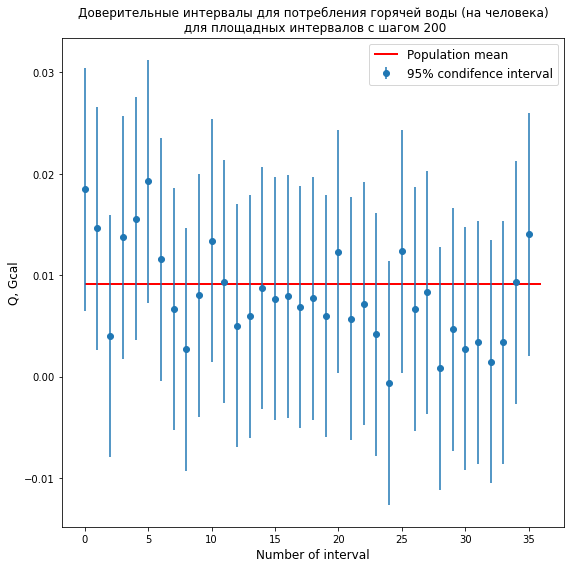

In [7]:
plt.figure(figsize=(9, 9))

plt.hlines(xmin=0, xmax=len(sample_sizes),
           y=pop_mean,
           linewidth=2.0,
           color="red", label='Population mean')

plt.errorbar(x=np.arange(0, len(sample_sizes), 1),
             y=sample_means,
             yerr=[(top-bot)/2 for top, bot in intervals],
             fmt='o', label='95% condifence interval')

plt.xlabel('Number of interval', fontsize=12)
plt.ylabel('Q, Gcal', fontsize=12)
plt.legend(fontsize=12)
plt.title('Доверительные интервалы для потребления горячей воды (на человека)\n для площадных интервалов с шагом 200')
plt.show()

### Добавим в датасет новый столбец потребления тепла без учета ГВС: для показаний с типом измерения "Heating" он равен столбцу "Q" общего теплопотребления, а для показаний с типом измерения "Heating+Hot Water" он равен столбцу "Q" минус среднее значение ГВС/чел, рассчитанное ранее, умноженное на число жильцов в доме

In [8]:
data['Q_without_HW'] = np.where(data['registrated'] == 'Heating + Hot water',
                                data['Q'] - pop_mean*data['Number_of_inhabitants'], data['Q'])

In [9]:
data.head()

,Date,М1_t,М2_t,delta_М_t,Т1,Т2,delta_Т,Q,USPD,YYYYMM,...,type,area,floors,walls_material,year_of_construction,area_of_building,temp,Address,Number_of_inhabitants,Q_without_HW
0,2013-12-01,93.950333,84.168098,9.782235,65.859886,43.560223,22.299663,2.104783,1,201312,...,1105,2707.4,5,panel,1983,4401.0,-0.157917,"Иркутский тр. , д.196",102.0,1.170587
1,2013-12-01,169.336258,169.643768,-0.307510,66.641441,49.602718,17.038723,2.892227,3,201312,...,2105,3358.4,5,brick,1974,3610.4,-0.157917,"Иркутский тр. , д.104-а",133.0,1.674108
2,2013-12-01,98.604866,100.520248,-1.915382,67.661072,41.020565,26.640507,2.630709,4,201312,...,2105,3153.5,5,brick,1975,3150.2,-0.157917,"Иркутский тр. , д.108",119.0,1.540813
3,2013-12-01,121.030000,115.590000,5.440000,66.470000,50.350000,16.120000,1.949000,10,201312,...,1105,2646.5,5,panel,1982,2932.7,-0.157917,"Фрунзе пр. , д.67/1",100.0,1.033121
4,2013-12-01,100.120705,102.018661,-1.897956,67.699661,40.780910,26.918751,2.698659,12,201312,...,2105,3187.5,5,brick,1976,3456.2,-0.157917,"Иркутский тр. , д.114",132.0,1.489699


### Визуализируем полученный результат: построим гистограммы теплопотребления без учета ГВС (по новому столбцу)

In [10]:
uspd_list = data['USPD'].drop_duplicates()
uspd_dict = {}
for uspd in uspd_list:
    uspd_dict.update({uspd: len(data.loc[data['USPD'] == uspd].index)})

In [11]:
def hist_mod(data, area_left_edge, width):
    """
    Эта функция разделяет измерения по типу регистрируемых данных в указанном площадном интервале\
    при этом делая количетсво измерений сравнимым. Строит гистограммы для обоих типов по столбцу\
    пересчитанного теплопотребления, считает некоторые статистики, строит сравнительный график\
    для полученных гистограмм

    Parameters
    ----------
    data: pandas DataFrame
        исходные данные

    area_left_edge: float
        левая граница площадного интервала

    width: float
        ширина площадного интервала

    Returns
    -------
    uspd_h: ndarray
        список УСПД по типу регистрации "Heating"

    uspd_hh: ndarray
        список УСПД по типу регистрации "Heating + Hot water"
    """

    uspd_h = list(set(data[(data['registrated'] == 'Heating') & (data['area'] >= area_left_edge)
                           & (data['area'] <= area_left_edge+width)]['USPD']))

    uspd_hh = list(set(data[(data['registrated'] == 'Heating + Hot water') & (data['area'] >= area_left_edge)
                            & (data['area'] <= area_left_edge+width)]['USPD']))

    # Делаем количество измерений разных типов сравнимым
    uspd_hh.sort(key=lambda x: uspd_dict[x], reverse=True)
    readings_count = 0
    new_uspd_hh = []

    for uspd in uspd_hh:
        if (readings_count > (stop := sum([uspd_dict[x] for x in uspd_h]))):
            break
        new_uspd_hh.append(uspd)
        readings_count += uspd_dict[uspd]

    uspd_hh = new_uspd_hh

    data_h = data[data['USPD'].isin(uspd_h)]['Q_without_HW']
    data_hh = data[data['USPD'].isin(uspd_hh)]['Q_without_HW']

    # Строим гистограммы
    bin_width = 0.2
    n_bins_h = int(np.ceil((max(data_h) - min(data_h))/bin_width))
    n_bins_hh = int(np.ceil((max(data_hh) - min(data_hh))/bin_width))

    fig = plt.figure(figsize=(16, 14))
    fig.suptitle(
        f'Area in [{area_left_edge}, {area_left_edge+width}], bin_width={bin_width}', y=0.925, fontsize=16)

    ax1 = plt.subplot2grid((15, 2), (0, 0), rowspan=5)
    ax1.hist(data_h, bins=n_bins_h, color='olive',
             label='Heating', density=True, edgecolor='black')
    ax1.legend(loc=1, fontsize=12)
    ax1.set_xlim(-0.5, 12.5)
    ax1.set_ylim(0, 0.8)
    ax1.set_xlabel('Q, Gcal', fontsize=14)
    ax1.set_ylabel('Probability density', fontsize=14)

    ax2 = plt.subplot2grid((15, 2), (0, 1), rowspan=5)
    ax2.hist(data_hh, bins=n_bins_hh,
             color='crimson', label='Heating + Hot water w/o Hot water', density=True, edgecolor='black')
    ax2.legend(loc=1, fontsize=12)
    ax2.set_xlim(-10, 12.5)
    ax2.set_ylim(0, 0.8)
    ax2.set_xlabel('Q, Gcal', fontsize=14)
    ax2.set_ylabel('Probability density', fontsize=14)

    # Строим таблички со статистиками
    columns = ('mean', 'std', 'kurtosis', 'skewness')
    info_h = [['%.3f' % data_h.mean(), '%.3f' % data_h.std(), '%.3f' %
               stats.kurtosis(data_h), '%.3f' % stats.skew(data_h)]]
    info_hh = [['%.3f' % data_hh.mean(), '%.3f' % data_hh.std(), '%.3f' %
                stats.kurtosis(data_hh), '%.3f' % stats.skew(data_hh)]]

    ax3 = plt.subplot2grid((15, 2), (5, 0), rowspan=2)
    ax3.set_title(
        f'Количество измерений = {len(data_h)}', y=0.45, fontsize=14, loc='left')

    ax4 = plt.subplot2grid((15, 2), (5, 1), rowspan=2)
    ax4.set_title(
        f'Количество измерений = {len(data_hh)}', y=0.45, fontsize=14, loc='left')

    ax3.set_axis_off()
    ax4.set_axis_off()

    table1 = ax3.table(cellText=info_h, bbox=[
                       0, -0.2, 1, 0.6], colLabels=columns, cellLoc='center')
    table2 = ax3.table(cellText=info_hh, bbox=[
                       1.2, -0.2, 1, 0.6], colLabels=columns, cellLoc='center')
    table1.set_fontsize(14)
    table2.set_fontsize(14)

    # Строим сравнительных график для гистограмм
    ax4 = plt.subplot2grid((15, 2), (8, 0), rowspan=7, colspan=2)
    ax4.hist(data_h, bins=n_bins_h, label='Heating',
             density=True, alpha=1, color='olive', histtype='step')
    ax4.hist(data_hh, bins=n_bins_hh, label='Heating + Hot water',
             density=True, alpha=1, color='crimson', histtype='step')
    ax4.set_xlim(-10, 12.5)
    ax4.set_ylim(0, 0.8)
    ax4.set_title(
        f'Разница между гистограммами = {sum(data_hh)-sum(data_h):.2f}', fontsize=14)
    ax4.legend(fontsize=12)

    ax1.xaxis.set_tick_params(labelsize=14)
    ax2.xaxis.set_tick_params(labelsize=14)
    ax2.set_xticks([x for x in range(-9, 12, 2)])
    ax1.yaxis.set_tick_params(labelsize=14)
    ax2.yaxis.set_tick_params(labelsize=14)
    ax4.xaxis.set_tick_params(labelsize=14)
    ax4.yaxis.set_tick_params(labelsize=14)

    plt.show()

    return uspd_h, uspd_hh

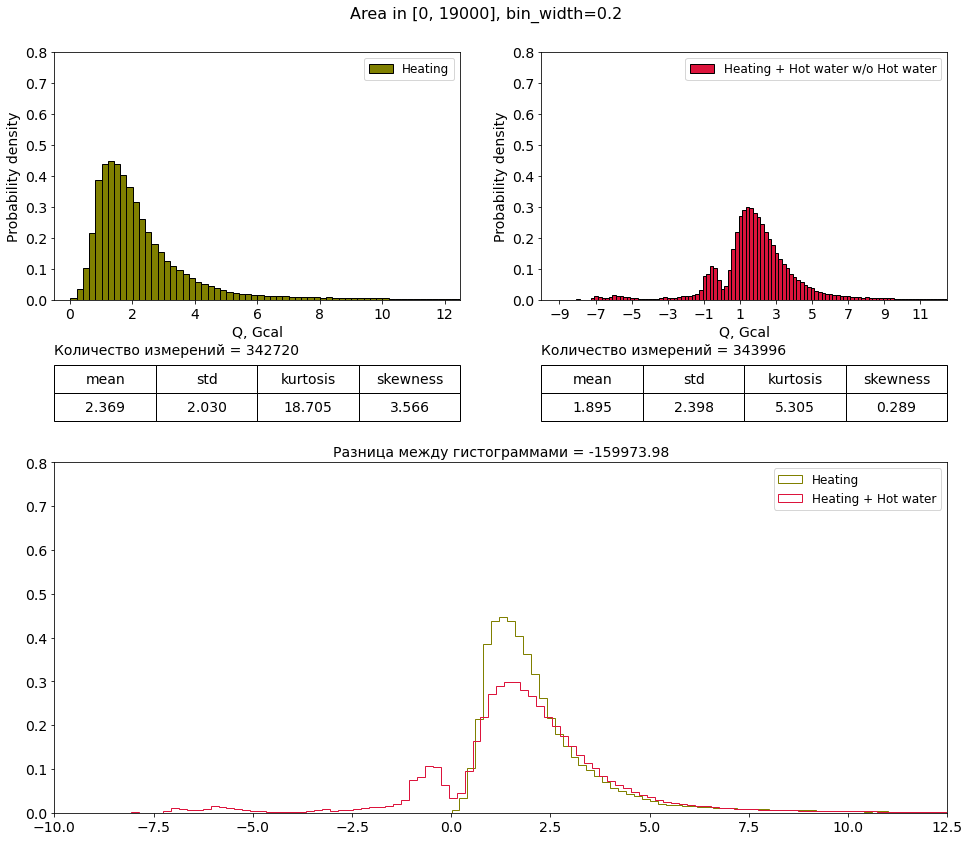

In [12]:
uspd_h, uspd_hh = hist_mod(data, 0, 19000)

In [13]:
print(f'Список USPD для "Heaing": ({len(uspd_h)})\n{uspd_h}\n\n'
      f'Список USPD для "Heaing + Hot water": ({len(uspd_hh)})\n{uspd_hh}')

Список USPD для "Heaing": (328)
[13, 34, 36, 37, 2090, 2091, 2092, 45, 46, 47, 48, 49, 50, 51, 2098, 2100, 2101, 2094, 2106, 68, 69, 70, 71, 72, 74, 75, 76, 2124, 78, 79, 80, 81, 82, 83, 85, 2134, 87, 2133, 90, 91, 92, 2138, 94, 95, 93, 102, 104, 105, 123, 124, 125, 126, 127, 129, 130, 156, 2205, 2206, 162, 164, 166, 167, 168, 169, 170, 188, 196, 231, 232, 233, 2281, 236, 240, 241, 242, 243, 244, 245, 246, 248, 249, 250, 251, 256, 257, 282, 285, 286, 290, 291, 300, 311, 316, 317, 332, 334, 336, 337, 338, 343, 344, 345, 349, 351, 352, 353, 354, 355, 356, 357, 359, 360, 366, 371, 372, 374, 400, 412, 413, 414, 415, 416, 483, 484, 485, 550, 551, 578, 582, 586, 587, 588, 589, 613, 621, 622, 623, 624, 625, 626, 627, 628, 631, 632, 633, 634, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 653, 654, 655, 656, 657, 678, 679, 680, 681, 683, 684, 685, 699, 752, 754, 755, 2805, 776, 777, 778, 779, 780, 782, 783, 784, 785, 786, 787, 788, 789, 790, 827, 3001, 954, 962, 3027, 3031, 3032, 3033, 992,